In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [198]:
import warnings
warnings.filterwarnings('ignore')

# Loading in the Dataset (Preprocess)

In [199]:
df = pd.read_csv('data/cleaned_merged_seasons.csv', index_col=0)
df = df.sort_values(['name', 'season_x', 'GW']).set_index(['total_points', 'name'], drop = True).groupby('name', as_index=False).shift().dropna(subset = ['season_x']).reset_index()

# Exploratory Data Analysis

Lets check for any missing values

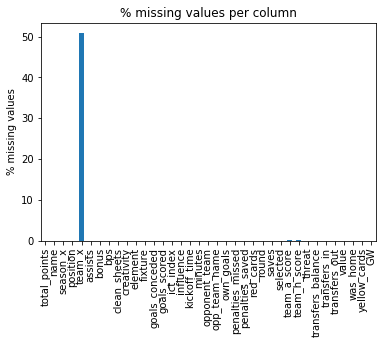

In [200]:
# Plot the percent of missing values per feature

missing_vals = (df.isna().sum()/df.shape[0])*100
ax = missing_vals.plot(kind='bar')
ax.set_title('% missing values per column')
ax.set_ylabel('% missing values')
plt.show()

Because we have so many missing values for team feature, lets drop this column entirely

In [201]:
df = df.drop(columns=['team_x'])

Let's analyze the features to see which ones are categorical versus which ones are numerical

In [202]:
# Find which features are numerical vs. categorical for EDA

num_vars = []
cat_vars = []
num_cat_vars = []

for column in list(df.columns): 
    
    if(df[column].dtype == 'float64' and len(df[column].unique())>=10): 
        num_vars.append(column)
    elif(df[column].dtype == 'float64'): 
        num_cat_vars.append(column)
    else: 
        cat_vars.append(column)
        
    print("{} has {} unique values of type {}".format(column, len(df[column].unique()), df[column].dtype))

cat_vars.remove('total_points')

total_points has 31 unique values of type int64
name has 982 unique values of type object
season_x has 6 unique values of type object
position has 4 unique values of type object
assists has 5 unique values of type float64
bonus has 4 unique values of type float64
bps has 113 unique values of type float64
clean_sheets has 2 unique values of type float64
creativity has 860 unique values of type float64
element has 734 unique values of type float64
fixture has 380 unique values of type float64
goals_conceded has 10 unique values of type float64
goals_scored has 5 unique values of type float64
ict_index has 273 unique values of type float64
influence has 528 unique values of type float64
kickoff_time has 1428 unique values of type object
minutes has 91 unique values of type float64
opponent_team has 20 unique values of type float64
opp_team_name has 31 unique values of type object
own_goals has 2 unique values of type float64
penalties_missed has 2 unique values of type float64
penalties_s

Examining the distribution for numerical features, numerical features with a small number of categories, and categorical features  ... 

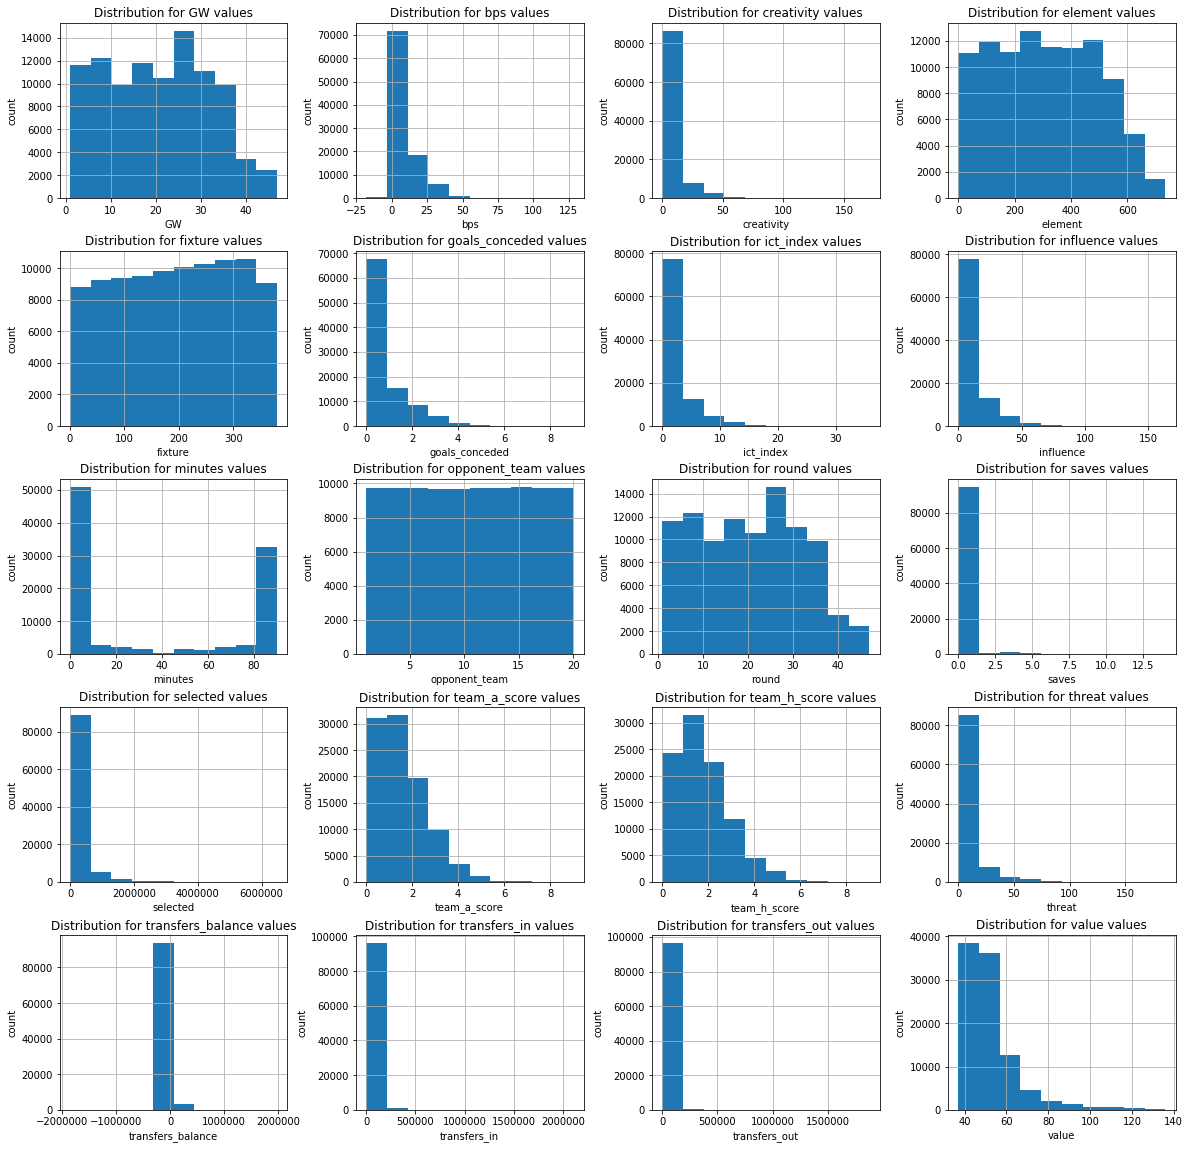

In [203]:
# Examine the distribution for numerical features (floats with 10+ unique values)

hist = df.hist(column=num_vars, layout=(5, 4), figsize=(20,20))
for ax, column_name in zip(hist.flatten(), sorted(num_vars)):
    ax.set_title("Distribution for {} values".format(column_name))
    ax.set_xlabel(column_name)
    ax.set_ylabel('count')

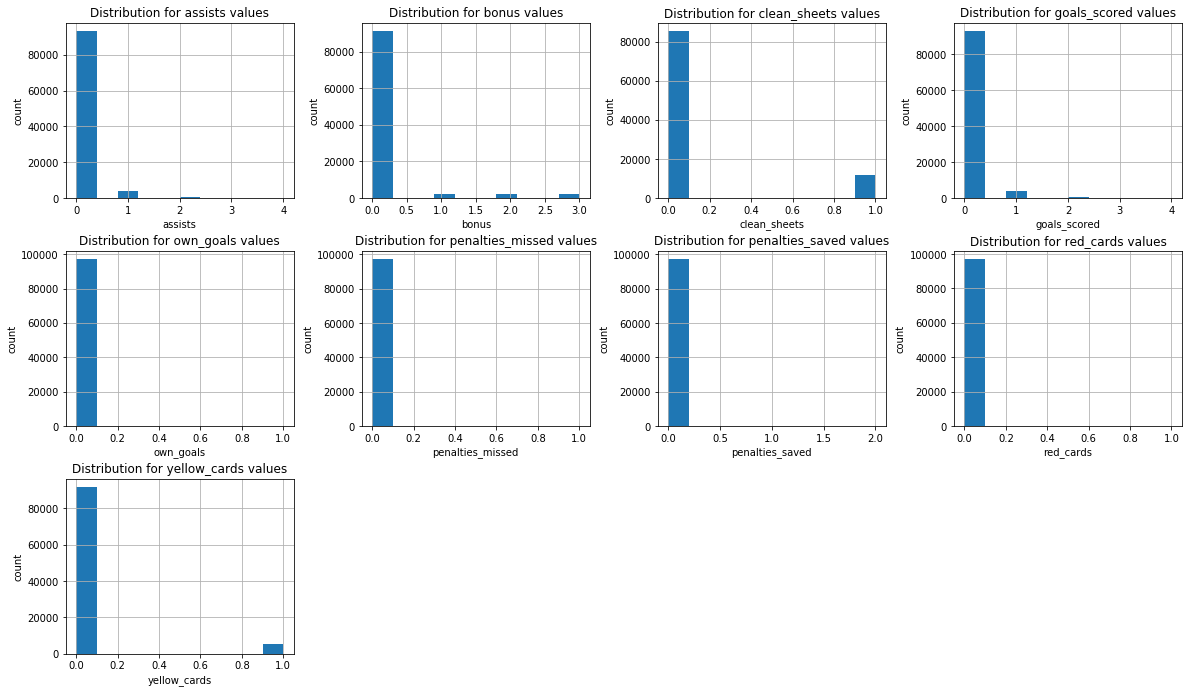

In [204]:
# Examine the distribution for numerical categorical features (floats with <10 unique values)

hist = df.hist(column=num_cat_vars, layout=(5, 4), figsize=(20,20))
for ax, column_name in zip(hist.flatten(), sorted(num_cat_vars)):
    ax.set_title("Distribution for {} values".format(column_name))
    ax.set_xlabel(column_name)
    ax.set_ylabel('count')

In [205]:
# Drop these as they are not categorical features we want to consider (just got included beacuse they are not floats)

for feature in ['name', 'season_x', 'kickoff_time']: 
    cat_vars.remove(feature)

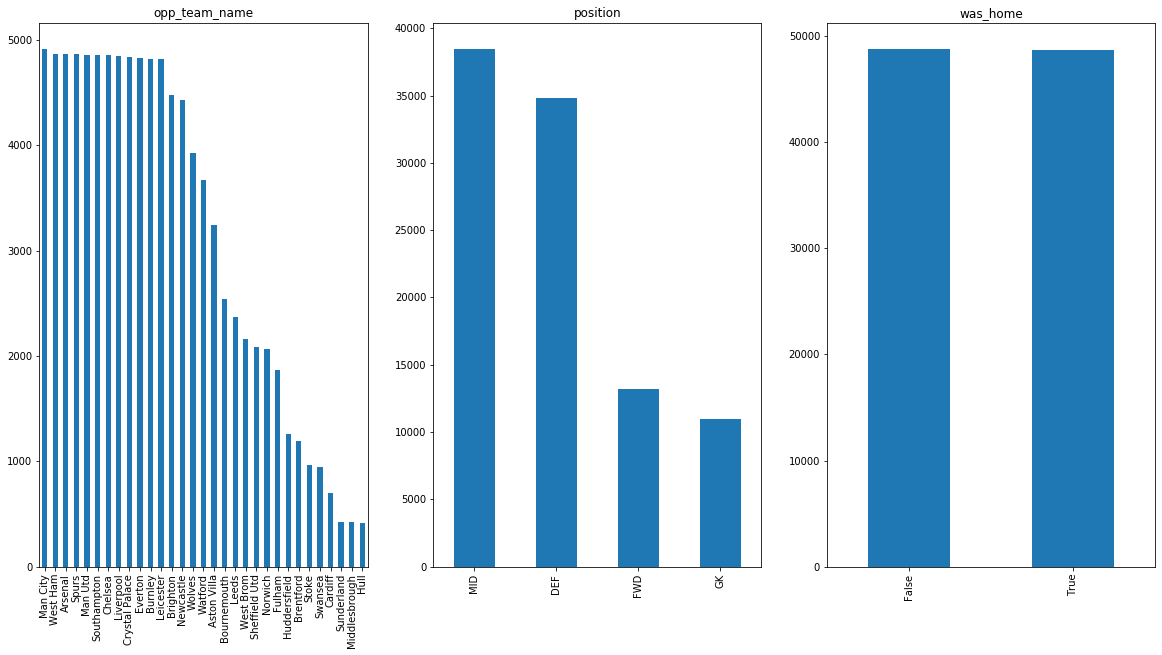

In [206]:
# Examine the distribution for categorical features (non float datatypes that aren't any of the above)

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,10))

for index, feature in enumerate(sorted(cat_vars)): 
    df[feature].value_counts().plot(ax=axes[index], subplots=True, kind='bar')

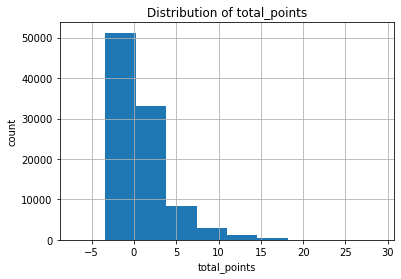

In [207]:
# Examine the distribution of y-labels

df.hist(column='total_points')
plt.title('Distribution of total_points')
plt.xlabel('total_points')
plt.ylabel('count')
plt.show()

Let's look at the correlation between features and target ...

In [208]:
# Split into df_x and df_y

df_x = df.drop(columns=['total_points'])
df_y = df['total_points']

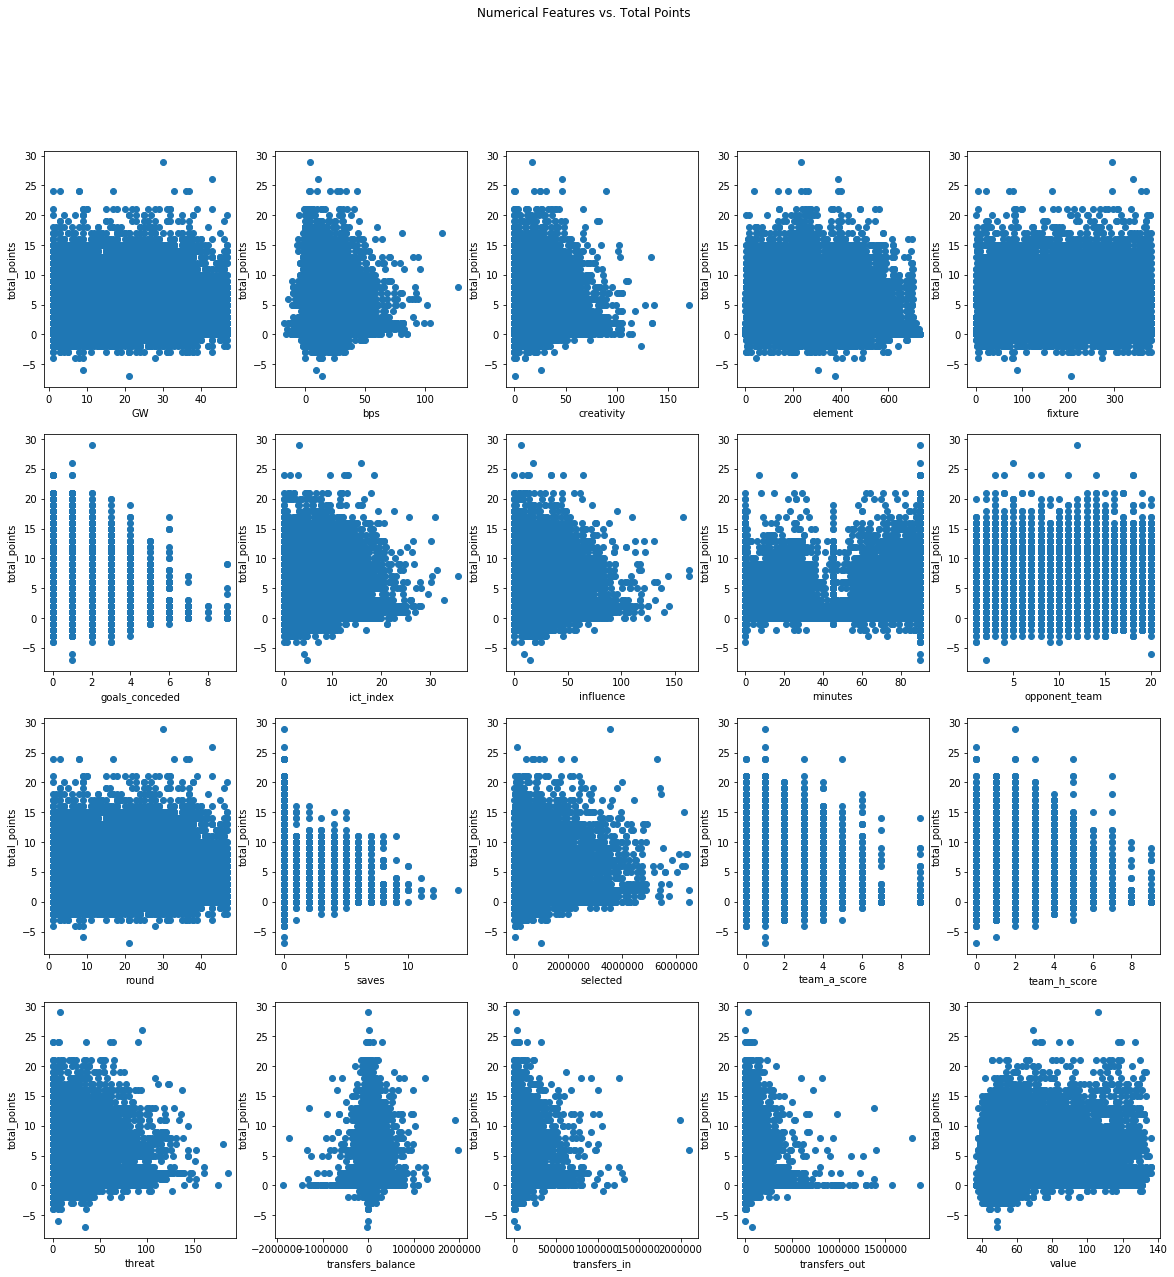

In [209]:
# Examine the correlation with the target for numerical features (floats with 10+ unique values)

fig, axes = plt.subplots(4, 5, figsize=(20,20))
fig.suptitle('Numerical Features vs. Total Points')

for index, feature in enumerate(sorted(num_vars)): 
    x_subplot = index//5
    y_subplot = index%5
    axes[x_subplot, y_subplot].scatter(df_x[feature], df_y)
    axes[x_subplot, y_subplot].set_xlabel(feature)
    axes[x_subplot, y_subplot].set_ylabel('total_points')

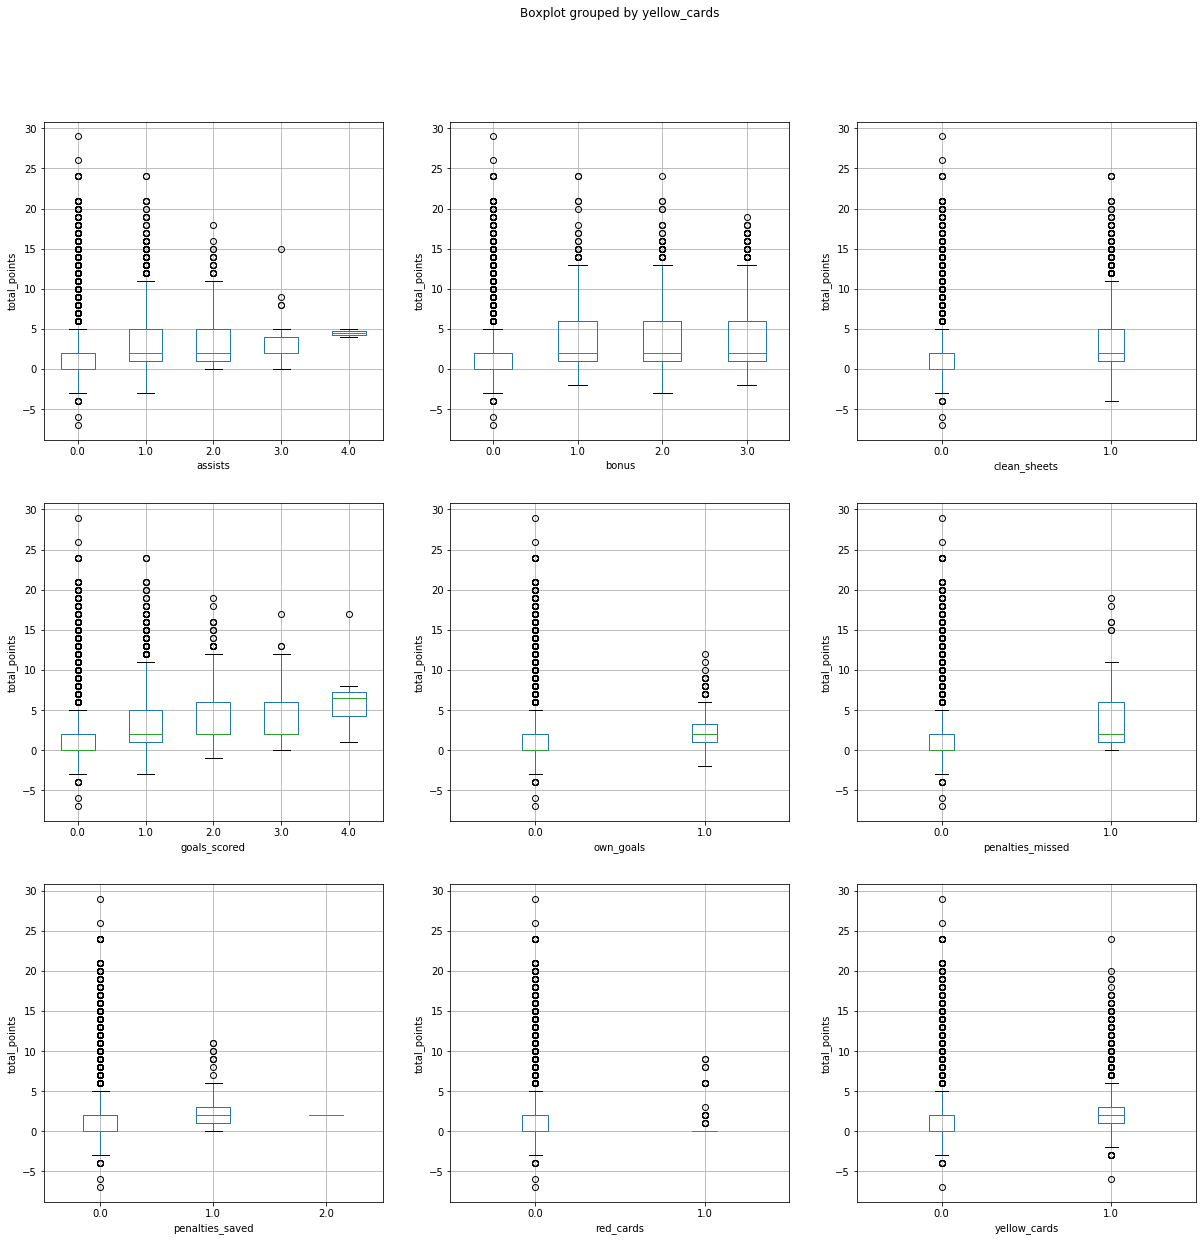

In [210]:
# Examine the correlation with the target for numerical categorical features (floats with <10 unique values)

fig, axes = plt.subplots(3, 3, figsize=(20,20))

for index, feature in enumerate(sorted(num_cat_vars)): 
    x_subplot = index//3
    y_subplot = index%3
    boxplt = df.boxplot(column=['total_points'], by=[feature], ax=axes[x_subplot, y_subplot])
    boxplt.set_xlabel(feature)
    boxplt.set_ylabel('total_points')
    boxplt.set_title('')

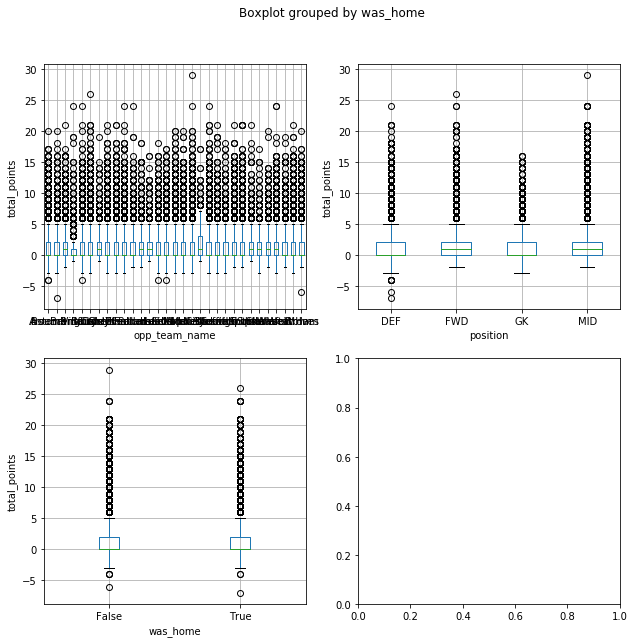

In [211]:
# Examine the correlation with the target for categorical features

fig, axes = plt.subplots(2, 2, figsize=(10,10))

for index, feature in enumerate(sorted(cat_vars)): 
    x_subplot = index//2
    y_subplot = index%2
    boxplt = df.boxplot(column=['total_points'], by=[feature], ax=axes[x_subplot, y_subplot])
    boxplt.set_xlabel(feature)
    boxplt.set_ylabel('total_points')
    boxplt.set_title('')

Let's look at highly correlated features

In [212]:
corr_matrix = df_x.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
assists,1.000000,0.304041,0.398176,0.128119,0.397368,-0.041086,-0.010267,0.092566,0.115453,0.407686,0.373167,0.211019,0.006170,0.005988,0.014919,-0.005675,0.002677,-0.010494,-0.030982,0.145866,0.074059,0.085397,0.245588,0.053979,0.124639,0.072712,0.195012,0.045286,-0.010494
bonus,0.304041,1.000000,0.649463,0.280693,0.299430,-0.050917,-0.008618,0.031050,0.614866,0.536415,0.624663,0.280469,0.003854,-0.004406,0.012245,0.103948,-0.008589,-0.009053,0.107650,0.180645,-0.002755,-0.000088,0.372523,0.068262,0.147611,0.080185,0.188857,0.020362,-0.009053
bps,0.398176,0.649463,1.000000,0.506732,0.517097,-0.132964,-0.027732,0.325890,0.576283,0.775060,0.901690,0.748219,0.005895,0.004012,0.004001,0.077467,-0.033039,-0.027876,0.229433,0.298664,0.016608,0.044742,0.471809,0.111397,0.226223,0.113618,0.241175,0.112546,-0.027876
clean_sheets,0.128119,0.280693,0.506732,1.000000,0.278300,-0.081944,-0.008962,-0.203471,0.126210,0.344953,0.327604,0.447744,0.003448,-0.015294,0.014944,0.008033,-0.003178,-0.006324,0.064830,0.185112,-0.173763,-0.133324,0.241958,0.084472,0.151608,0.062717,0.162936,0.097405,-0.006324
creativity,0.397368,0.299430,0.517097,0.278300,1.000000,-0.104529,-0.023947,0.256178,0.218418,0.764451,0.491663,0.513158,0.002507,0.005241,0.042256,-0.012769,0.005176,-0.024906,-0.074546,0.264039,0.006039,0.022865,0.455812,0.108318,0.237713,0.131331,0.347541,0.135163,-0.024906
element,-0.041086,-0.050917,-0.132964,-0.081944,-0.104529,1.000000,0.108111,-0.092699,-0.045035,-0.128834,-0.123976,-0.163238,-0.026050,-0.007579,-0.012198,-0.002355,-0.008181,0.100872,-0.026181,-0.131993,0.000280,-0.005175,-0.088606,0.007950,-0.055968,-0.076668,-0.173234,-0.046289,0.100872
fixture,-0.010267,-0.008618,-0.027732,-0.008962,-0.023947,0.108111,1.000000,-0.034294,-0.010036,-0.028938,-0.029836,-0.041070,0.009686,-0.004300,-0.002519,0.000365,-0.008981,0.977056,-0.009431,0.005855,-0.024320,-0.003174,-0.017650,0.013288,-0.047119,-0.073548,-0.052917,-0.020842,0.977056
goals_conceded,0.092566,0.031050,0.325890,-0.203471,0.256178,-0.092699,-0.034294,1.000000,0.099200,0.348883,0.383188,0.604167,-0.007915,0.072226,0.019637,0.031537,0.059726,-0.034014,0.156895,0.147711,0.197973,0.221877,0.216811,0.040900,0.110073,0.073478,0.094410,0.176473,-0.034014
goals_scored,0.115453,0.614866,0.576283,0.126210,0.218418,-0.045035,-0.010036,0.099200,1.000000,0.620354,0.681025,0.219669,0.003569,0.002607,0.047853,-0.005827,-0.000337,-0.010366,-0.034364,0.185758,0.076065,0.087086,0.569485,0.070076,0.168196,0.101905,0.287086,0.051547,-0.010366
ict_index,0.407686,0.536415,0.775060,0.344953,0.764451,-0.128834,-0.028938,0.348883,0.620354,1.000000,0.838599,0.671802,0.003712,0.013177,0.073265,0.027578,-0.000006,-0.030818,0.061819,0.353517,0.035018,0.054238,0.838204,0.141659,0.307935,0.168294,0.431210,0.158473,-0.030818


In [213]:
# Take a loot at the most highly correlated features

df_x.corr().abs().unstack().sort_values(kind='quicksort')[-41:-31]

threat     ict_index    0.838204
ict_index  threat       0.838204
           influence    0.838599
influence  ict_index    0.838599
           bps          0.901690
bps        influence    0.901690
fixture    round        0.977056
           GW           0.977056
GW         fixture      0.977056
round      fixture      0.977056
dtype: float64

# Let's try to apply some models on the raw data (purely on individual player data)

We'll start with decision trees becuase these handle categorical features on the fly

In [214]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Get rid of any non-individual statistics or statistics that don't capture player performance
non_individual_stats = ['name', 'season_x', 'kickoff_time', 'opponent_team', 'opp_team_name', 'team_a_score', 'team_h_score', 'GW']
df_x = df_x.drop(columns=non_individual_stats, errors='ignore')

# Split the dataset into train and test using STRUCTURED SPLITTING
x_dev, x_test, y_dev, y_test = train_test_split(df_x, df_y, test_size = 0.2, shuffle=False)

# Pre-processor that encodes position
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), ['position']), remainder="passthrough")

# A single decision tree

Optimal depth: 4
Mean Absolute Error: 1.2194220602576604


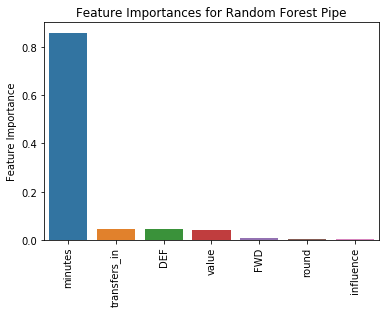

In [215]:
# Searching depths
param_grid = [{"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]}]

# Fit the random forest classifier
pipe = make_pipeline(preprocess, GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid))
pipe.fit(x_dev, y_dev)

# Get the optimal parameter
grid_search_results = pipe.named_steps["gridsearchcv"]
print("Optimal depth: " + str(grid_search_results.best_params_['max_depth']))

# Rebuild the classifier using optimal depth
pipe = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=grid_search_results.best_params_['max_depth']))
pipe.fit(x_dev, y_dev)

# Test accuracies on the most recent 20% of data
y_pred = pipe.predict(x_test)
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_pred)))

# Build the list of feature names
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
ohe_feature_names = [x[3:] for x in ohe_feature_names]
feature_names = ohe_feature_names + list(df_x.drop(columns=['position']).columns)

# Get the importance of features
feat_imps = zip(feature_names, pipe[1].feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))

# Plot the results
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importances for Random Forest Pipe')
ax.set_ylabel('Feature Importance')
plt.show()

As you can see one feature dominates (this is likely depending on the data (the first split that occurs). To get more variation and see other features that might contribute let's add some randomness using a random forest classifier then average all feature importances.

# Random Forest Classifier

Mean Absolute Error: 1.2299953805882051


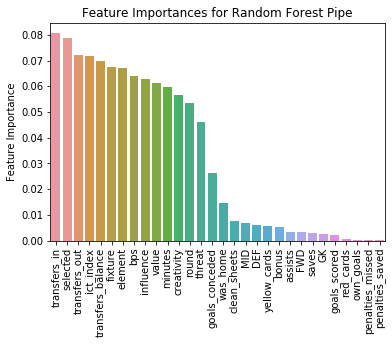

In [216]:
# Create the random forest pipeline
pipe = make_pipeline(preprocess, RandomForestClassifier())
pipe.fit(x_dev, y_dev)

# Test accuracies on the most recent 20% of data
y_pred = pipe.predict(x_test)
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_pred)))

# Build the list of feature names
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
ohe_feature_names = [x[3:] for x in ohe_feature_names]
feature_names = ohe_feature_names + list(df_x.drop(columns=['position']).columns)

# Get the importance of features
feat_imps = zip(feature_names, pipe[1].feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))

# Plot the results
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importances for Random Forest Pipe')
ax.set_ylabel('Feature Importance')
plt.show()

# Linear Regression with l1 regularization: do any values get pushed to 0? 

Note here we have not done any normalization yet, therefore the actual magnitude of the bars don't mean much. We are just using this technique to see which weights are 0 and which actually take on values.

In [ ]:
from sklearn import linear_model

In [244]:
# Fit the linear classifier
pipe = make_pipeline(preprocess, linear_model.Lasso(alpha=1.0))
pipe.fit(df_x, df_y)

# Test accuracies on the most recent 20% of data
y_pred = pipe.predict(x_test)
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_pred)))

# Plot feature importances using coefficient
plt.figure(figsize=(20,10))
plt.bar(feature_names,pipe[1].coef_)
plt.xticks(rotation=90)
plt.axhline(y=0, color='b', linestyle='--', lw=0.5)
plt.show()

Mean Absolute Error: 1.4564854704343728


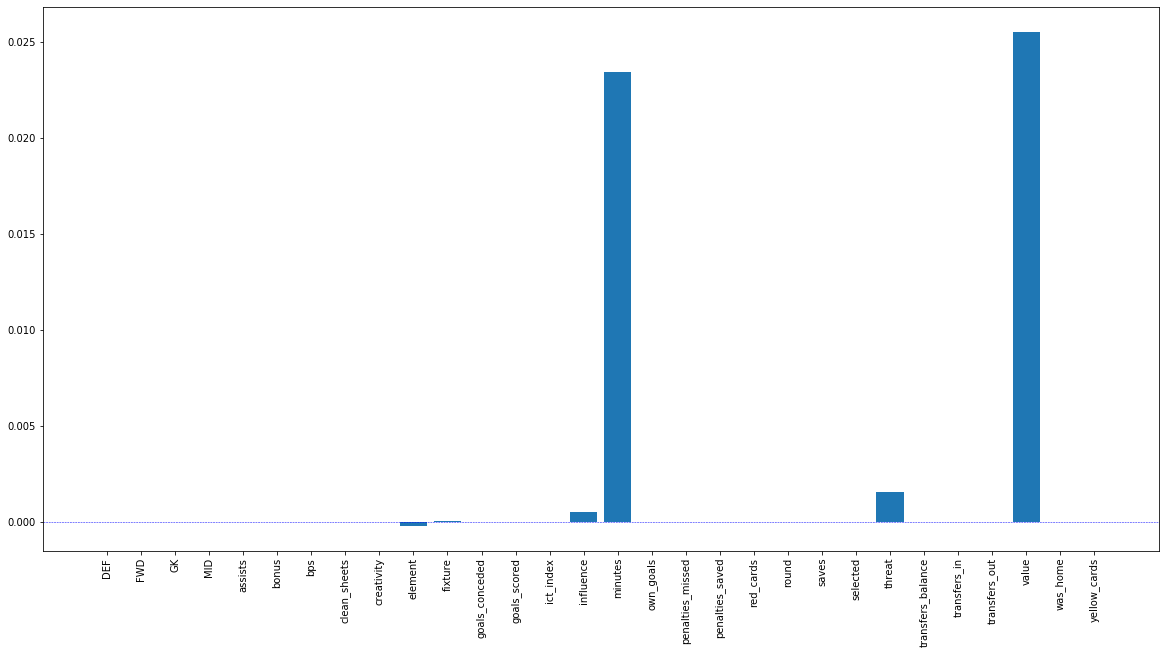

In [245]:
plt.figure(figsize=(20,10))
plt.bar(feature_names,pipe[1].coef_)
plt.xticks(rotation=90)
plt.axhline(y=0, color='b', linestyle='--', lw=0.5)
plt.show()

Let's look at the lasso path similar to the in class example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [303]:
# Search coefficients as a function of alpha values

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(preprocess.transform(df_x), df_y)
    coefs.append(lasso.coef_)

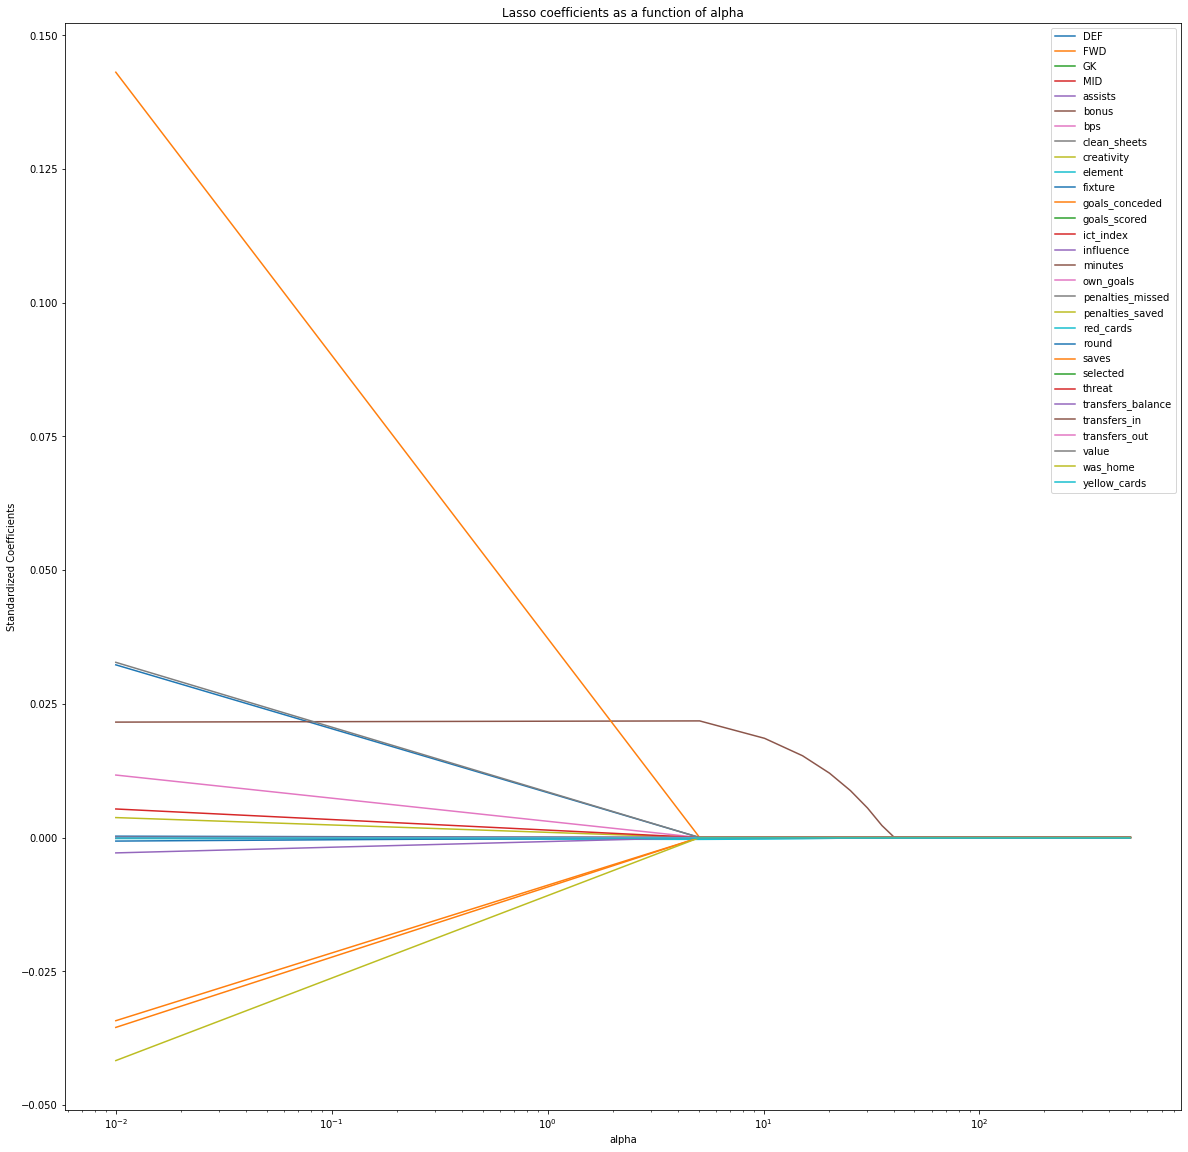

In [304]:
# Plot the results (still needs to be cleaned up/formatted better)

plt.figure(figsize=(20,20))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.legend(feature_names)